# Data Loding 

In [2]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# loading image data...
def data_loader(folder_dir):
    # folder_dir = "./data/images/"
    image_dataset = []
    mask_dataset = []
    for images in os.listdir(folder_dir+'/images'):
        image = cv2.imread(folder_dir+'/images/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, (128, 128))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
        mask = cv2.imread(folder_dir+'/masks/10066_mask.png', 1)
        mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
        mask = Image.fromarray(mask)
        mask = np.array(mask)
        mask_dataset.append(mask)
    return image_dataset, mask_dataset

In [3]:
img_height = 4032
img_width = 3024

image_dataset, mask_dataset = data_loader("./data")
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
mask_dataset.shape
image_dataset.shape

(1221, 480, 640, 3)

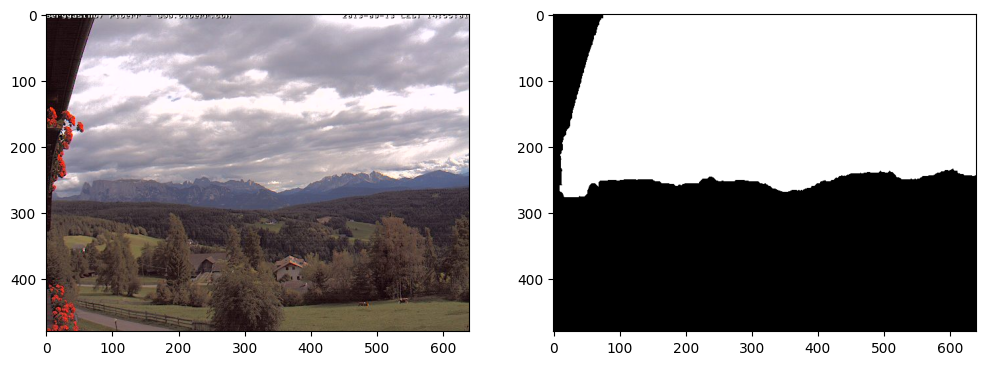

In [4]:
import random

image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [5]:
print(((mask_dataset[0] < 255).astype(int))[:,:,0])

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [6]:
def rgb_to_labels(img):
  label_seg = np.zeros(img.shape,dtype=np.uint8)
  new_img = (img < 255).astype(int)
  return new_img[:,:,0]

labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_labels(mask_dataset[i]) # calling rgb to labels for each images...
  labels.append(label)

In [7]:
labels = np.array(labels)
# labels = np.expand_dims(labels, axis=3) # adding channel dim...
print(labels.shape)

(1221, 480, 640)


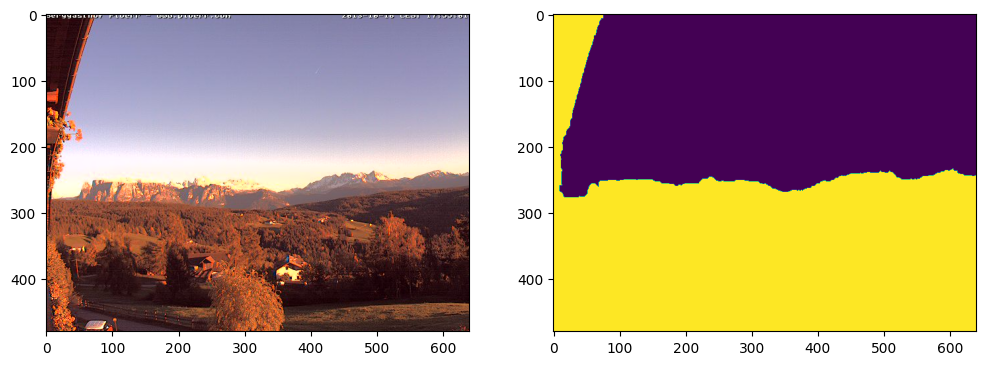

In [8]:
#Another Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:])
plt.show()

In [9]:
from tensorflow.keras.utils import to_categorical
n_classes = len(np.unique(labels)) # 23 classes...
labels_cat = to_categorical(labels, num_classes=n_classes) #labels one hot encoded

In [10]:
print(labels.shape)

(1221, 480, 640)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size = 0.20, random_state = 42) # train test split for data...

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p
 
def upsample_block(x, conv_features, n_filters):
  # upsample
  x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
  # concatenate
  x = layers.concatenate([x, conv_features])
  # dropout
  x = layers.Dropout(0.3)(x)
  # Conv2D twice with ReLU activation
  x = double_conv_block(x, n_filters)
  return x
 

In [43]:
def build_unet_model():
   # inputs
   inputs = layers.Input(shape=(480,640,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   # f3, p3 = downsample_block(p2, 256)
   # # 4 - downsample
   # f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   # bottleneck = double_conv_block(p2, 1024)
   bottleneck = double_conv_block(p2, 256)
   # decoder: expanding path - upsample
   # 6 - upsample
   # u6 = upsample_block(bottleneck, f4, 512)
   # # 7 - upsample
   # u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(bottleneck, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model
unet_model = build_unet_model()


In [46]:
unet_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")


In [47]:
STEPS_PER_EPOCH = 976 // 64
model_history = unet_model.fit(X_train[:40], 
          y_train[:40],
          # batch_size=64, 
          # steps_per_epoch=STEPS_PER_EPOCH,
          epochs=1,
          verbose=1,
          validation_data=(X_test, y_test))

2/2 [==============================] - 340s 187s/step - loss: 141.1583 - accuracy: 0.4990 - val_loss: 72.4352 - val_accuracy: 0.5001


In [ ]:
# !pip install -U -q segmentation-models
# !pip install -q tensorflow==2.2.1
# !pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

import keras
# from keras.utils import generic_utils
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

# using weights from pretained resnet model...
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input...
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

# define model...
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

model_resnet_backbone.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_68 (ZeroPad  (None, None, None, 3)        0         ['bn_data[0][0]']             
 ding2D)                                                                                          
                                                                                            

In [ ]:
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=32, 
          epochs=1,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

model_resnet_backbone.save('../models/resnet_backbone.hdf5')

In [ ]:
# randomly flip image and mask combinations
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

In [16]:
# model = load_model('model_v1.keras')
model = unet_model

In [18]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

8/8 [==============================] - 161s 20s/step


AxisError: axis 3 is out of bounds for array of dimension 3

In [ ]:
# randomly selecting an image from the test set and making prediction...
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 243ms/step


In [40]:
print(y_train[:40].shape)

(40, 480, 640)


1/1 [==============================] - 1s 636ms/step
(1, 480, 640)


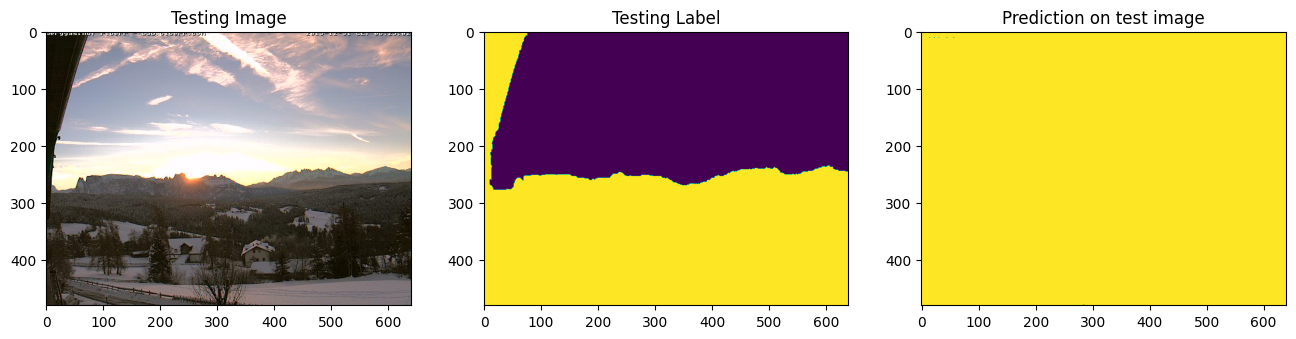

In [81]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

# randomly selecting an image from the test set and making prediction...
test_img_number = random.randint(0, len(X_test))
# test_img = X_test[test_img_number]
# ground_truth=y_test[test_img_number]
test_img = X_train[3]
ground_truth=y_test[3]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = model.predict(test_img_input)
# prediction = create_mask(prediction)
predicted_img=np.argmax(prediction, axis=3)
print(predicted_img.shape)



# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img[0])
plt.show()

